# Train a beta-TCVAE
We start by training a beta-TCVAE using `disentanglement_lib` https://github.com/google-research/disentanglement_lib
This code assumes `disentanglement_lib` has been installed (along with the datasets)

In [ ]:
%load_ext autoreload
%autoreload 2

import os
from disentanglement_lib.methods.unsupervised import train
from keras import metrics
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) 

In [ ]:
from disentanglement_lib.data.ground_truth import cars3d
dta = cars3d.Cars3D()
overwrite = True

In [3]:
import tensorflow_hub as hub

beta_tcvae_model_url ='path to beta-tcvae'
with hub.eval_function_for_module(beta_tcvae_model_url) as f:
    # Save reconstructions.
    images1 = dta.images[:9000]
    means1 = f(
        dict(images=images1), signature="gaussian_encoder",
        as_dict=True)["mean"]
    reconstructions1 = f(
        dict(images=images1), signature="reconstructions",
        as_dict=True)["images"]

    images2 = dta.images[9000:]
    means2 = f(
        dict(images=images2), signature="gaussian_encoder",
        as_dict=True)["mean"]
    reconstructions2 = f(
        dict(images=images2), signature="reconstructions",
        as_dict=True)["images"]

    images = np.concatenate((images1, images2), axis=0)
    means = np.concatenate((means1, means2), axis=0)
    reconstructions = np.concatenate((reconstructions1, reconstructions2), axis=0)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [15]:
import sys
sys.path.insert(0, '../source_tf/utils')
sys.path.insert(0, '../source_tf/models')
from data_helpers import DataProviderLezama
import numpy as np
import time, math
from misc import merge

In [27]:
tr_data_loader = DataProviderLezama(images, means, reconstructions, batch_size=32, shuffle_order=True)

# Train DS-VAE using beta-TCVAE outputs

### Define models

In [29]:
from lezama_models import encoder_lezama, decoder_lezama

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Hyperparameters
Define hyperparameters, optimizers, and learning rates

In [30]:
lr = 0.0003
weight_decay = 1e-6
#can't do weight decay in this version of tensorflow
optimizer = tf.train.AdamOptimizer(lr, beta1=0.9)
lambda_y  = .25
lambda_diff = 0.1
lambda_cov = 1e-3

### Graph

In [39]:
tf.compat.v1.reset_default_graph()

In [40]:
batchsize = 32
latent_noise_dim = 15 # size of z
input_shape = [64, 64, 3]

x_image_ph = tf.placeholder(tf.float32, [batchsize] + input_shape, name="x_image_ph")
x_image_j_ph = tf.placeholder(tf.float32, [batchsize] + input_shape, name="x_image_j_ph")

x_hat_t_ph = tf.placeholder(tf.float32, [batchsize] + input_shape, name="recon_t_ph")
x_hat_t_j_ph = tf.placeholder(tf.float32, [batchsize] + input_shape, name="recon_t_j_ph")

y_t_ph = tf.placeholder(tf.float32, [batchsize] + [10], name="y_t_ph")
y_t_j_ph = tf.placeholder(tf.float32, [batchsize] + [10], name="y_t_j_ph")

In [41]:
#Infer z for paired images
mu_s = encoder_lezama(x_image_ph, latent_noise_dim)
mu_s_j = encoder_lezama(x_image_j_ph, latent_noise_dim, reuse=True)

#Separate into DR and nuisance factors for both images
y_s = mu_s[:,:10]  # DR factors
z_s = mu_s[:,10:]  # nuisance factors
y_s_j = mu_s_j[:,:10]  # DR factors paired image
z_s_j = mu_s_j[:,10:]  # nuisance factors paired image

#Create latent factor with DR factors of paired image, but nuisance factors of original image
swapped_mu = tf.concat((y_s_j, z_s), axis=1)

#Obtain reconstruction for both the original latent factors, but also with the swapped factors
x_hat_s = decoder_lezama(mu_s, input_shape, dim=latent_noise_dim, reuse=False)
x_hat_s_j = decoder_lezama(swapped_mu, input_shape, dim=latent_noise_dim, reuse=True)

In [42]:
#reconstruction loss
rec_loss = metrics.mse(tf.reshape(x_image_ph, [-1]), tf.reshape(x_hat_s, [-1]))

#jacobian loss (latent loss + delta pairwise-reconstruction loss)
delta_recon_t = x_hat_t_j_ph - x_hat_t_ph
delta_recon_s = x_hat_s_j - x_hat_s
latent_loss = lambda_y*metrics.mse(tf.reshape(y_t_ph, [-1]), tf.reshape(y_s, [-1]))
delta_loss = lambda_diff*metrics.mse(tf.reshape(delta_recon_t, [-1]), tf.reshape(delta_recon_s, [-1]))
jacobian_loss = latent_loss + delta_loss

#cross-covariance loss
mu_y_s = tf.reduce_mean(y_s, 0)
mu_z_s = tf.reduce_mean(z_s, 0)
dot_product = tf.matmul((y_s - mu_y_s), (z_s - mu_z_s), transpose_a=True)
cov_loss = lambda_cov*(tf.norm(dot_product)) / batchsize
total_loss = rec_loss + jacobian_loss + cov_loss

In [43]:
t_vars = tf.trainable_variables()
e_vars = [var for var in t_vars if 'encoder_lezama' in var.name]
d_vars = [var for var in t_vars if 'decoder_lezama' in var.name]

vae_optim1 = optimizer.minimize(total_loss, var_list=d_vars+e_vars)

optim_list = [vae_optim1]
eval_list = [x_hat_s, x_hat_s_j, rec_loss, jacobian_loss, cov_loss]
loss_dict = {'total_loss': total_loss}

### Start training

In [44]:
tic = time.time()
total_iterations = 0
nb_epoch = 1

config = tf.ConfigProto()
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
tf.initialize_all_variables().run()
dec_saver = tf.train.Saver(var_list=t_vars)

/afs/inf.ed.ac.uk/user/s17/s1727843/miniconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: [ 0] [   0] time: 2.6350, 
rec_loss: 0.20822465419769287
jacobian_loss: 19.363872528076172
cov_loss: 0.0026054750196635723


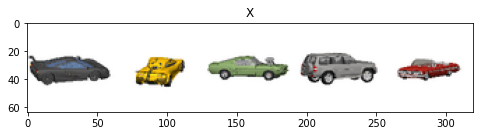

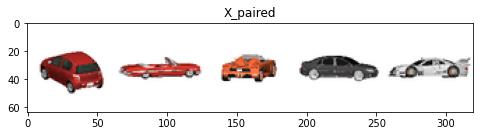

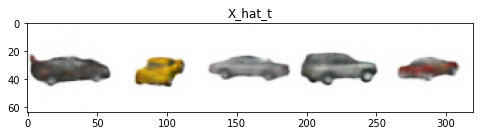

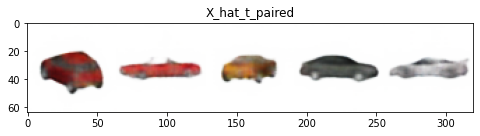

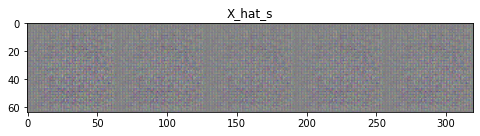

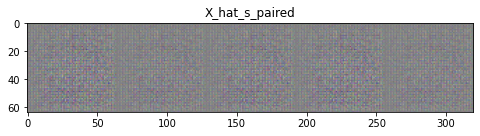

Epoch: [ 0] [ 100] time: 117.3601, 
rec_loss: 0.02072002924978733
jacobian_loss: 0.028794141486287117
cov_loss: 0.0003408289048820734


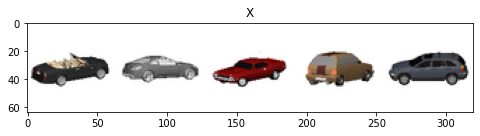

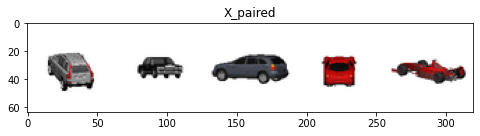

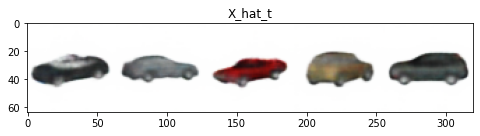

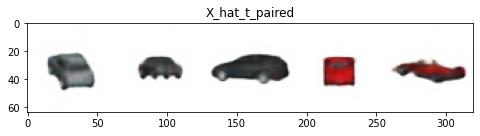

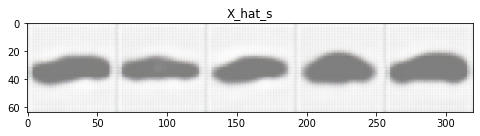

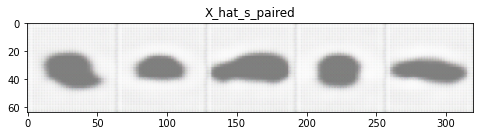

Epoch: [ 0] [ 200] time: 232.5684, 
rec_loss: 0.014885655604302883
jacobian_loss: 0.024498559534549713
cov_loss: 0.0002875588834285736


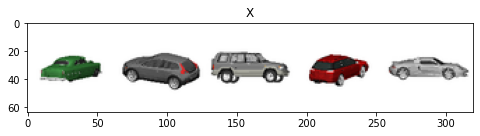

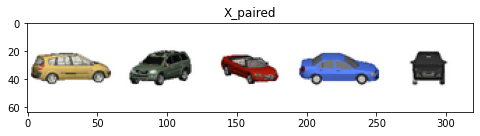

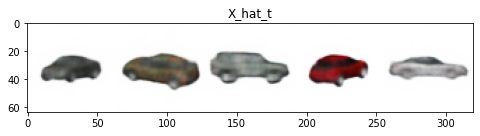

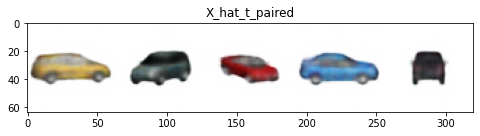

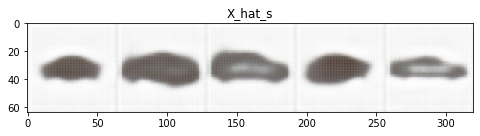

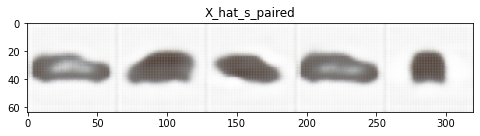

Epoch: [ 0] [ 300] time: 348.5178, 
rec_loss: 0.013545922935009003
jacobian_loss: 0.024335796013474464
cov_loss: 0.00036170013481751084


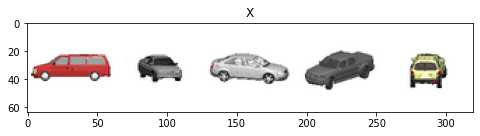

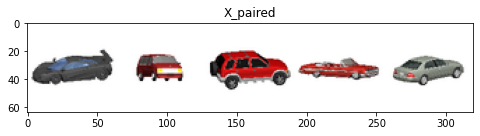

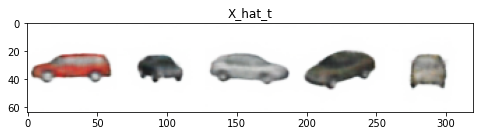

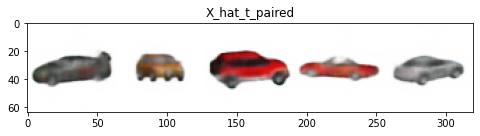

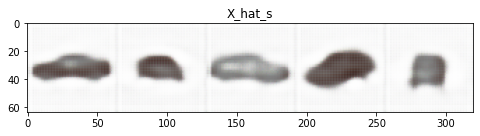

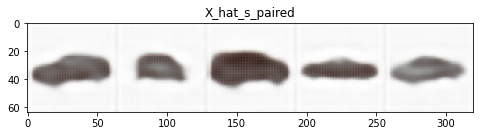

Epoch: [ 0] [ 400] time: 464.5011, 
rec_loss: 0.013052195310592651
jacobian_loss: 0.017277007922530174
cov_loss: 0.0005014122580178082


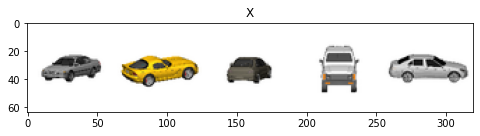

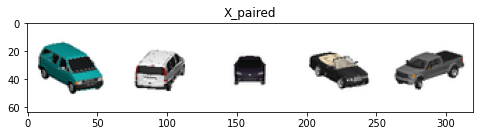

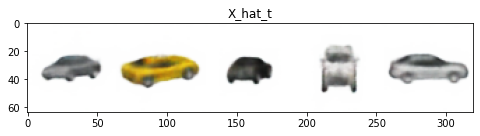

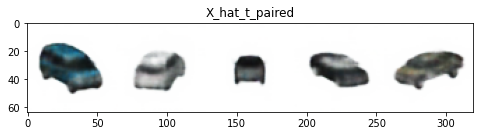

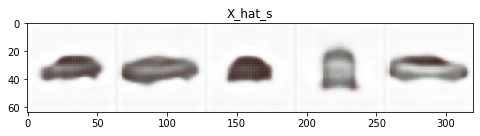

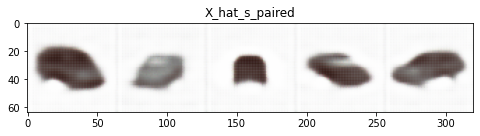

Epoch: [ 0] [ 500] time: 580.4117, 
rec_loss: 0.011862359941005707
jacobian_loss: 0.02279571443796158
cov_loss: 0.0005075528752058744


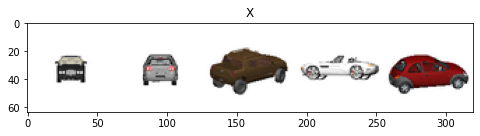

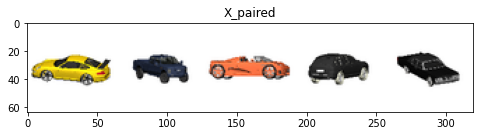

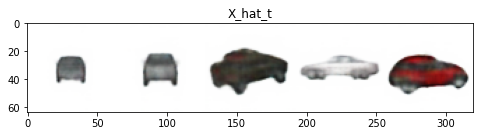

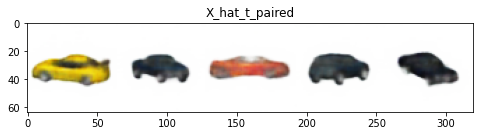

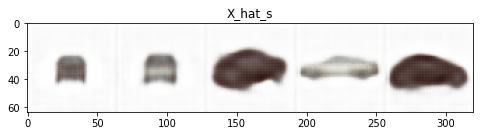

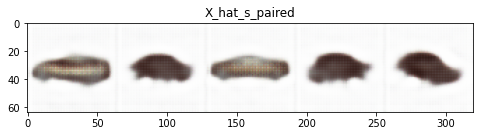

Epoch: [ 1] [  68] time: 698.5490, 
rec_loss: 0.011409279890358448
jacobian_loss: 0.01758413016796112
cov_loss: 0.0005067896563559771


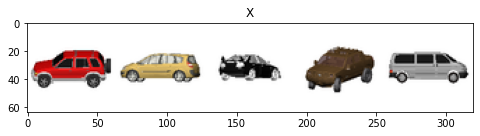

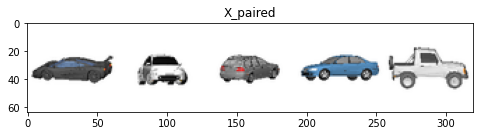

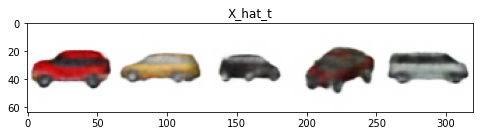

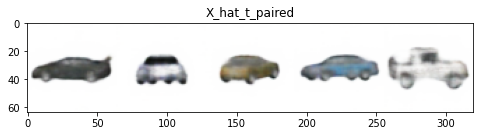

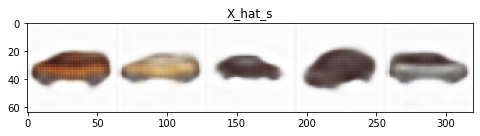

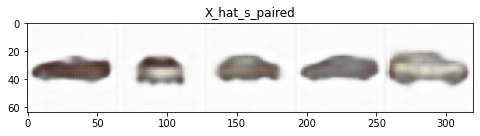


KeyboardInterrupt



In [46]:
for n in range(100):
    for (i, X) in enumerate(tr_data_loader):
        
        # images_batch, means_batch, reconstructions_batch, images_batch_next, means_batch_next, reconstructions_batch_next
        images_batch = X[0] #image (x)
        means_batch = X[1] # c (x)
        reconstructions_batch = sigmoid(X[2]) # y (x)
        images_batch_next = X[3] # image
        means_batch_next = X[4]
        reconstructions_batch_next = sigmoid(X[5])
        
        feed_dict = {x_image_ph: images_batch, x_image_j_ph: images_batch_next, x_hat_t_ph: reconstructions_batch, \
                     x_hat_t_j_ph: reconstructions_batch_next, y_t_ph: means_batch, y_t_j_ph: means_batch_next}
        
        _ = sess.run(optim_list, feed_dict=feed_dict)
        
        if total_iterations%100==0:
            print("Epoch: [%2d] [%4d] time: %4.4f, " % (n, i, time.time() - tic,))

            data = sess.run(eval_list, feed_dict = feed_dict)
            print('rec_loss: {}'.format(data[2]))
            print('jacobian_loss: {}'.format(data[3]))
            print('cov_loss: {}'.format(data[4]))
            
            sdata = images_batch[:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.gray()
            plt.title('X')
            plt.show()
            
            sdata = images_batch_next[:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.gray()
            plt.title('X_paired')
            plt.show()
            
            sdata = reconstructions_batch[:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.title('X_hat_t')
            plt.gray()
            plt.show()
            
            sdata = reconstructions_batch_next[:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.title('X_hat_t_paired')
            plt.gray()
            plt.show()

            sdata = data[0][:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.gray()
            plt.title('X_hat_s')
            plt.show()
            
            sdata = data[1][:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.gray()
            plt.title('X_hat_s_paired')
            plt.show()                
        total_iterations += 1